<h1 style= "font-weight: bold; border-bottom: 0px; padding-bottom: 0px;">
    Deep Learning Based Landmark Detection on Spine Images
</h1>

<h3 style="font-style: italic; margin-top: -10px; margin-bottom: 0px; padding-bottom:20px; border-bottom: 6px double #72727b; "> 
    Challenges with Image Preparation and Reproduction of Published Results
</h3>

##### **Author:** Jeanne Malécot

## Data exploration
---

In [18]:
import glob
import os
import skimage.io as skio
import matplotlib.pyplot as plt
import csv
import numpy as np

In [19]:
project_dir = os.getcwd()
path_data = os.path.join(project_dir, r"Ressources\boostnet_labeldata\data")
path_labels = os.path.join(project_dir, r"Ressources\boostnet_labeldata\labels")

In [20]:
#determine if the data folder exists
print(path_data)
if not os.path.exists(path_data):
    print("Data folder does not exist")

X_train = []
X_test = []
for path_img in glob.glob(os.path.join(path_data + "/training/*.jpg")):
    X_train.append(path_img)
for path_img in glob.glob(os.path.join(path_data + "/test/*.jpg")):
    X_test.append(path_img)

c:\Users\jeann\Documents\TelecomParis\Cours_Telecom\3A\PRIM-Project\PROJECT--Deep-Learning-Based-Landmark-Detection-on-Spine-Images\Ressources\boostnet_labeldata\data


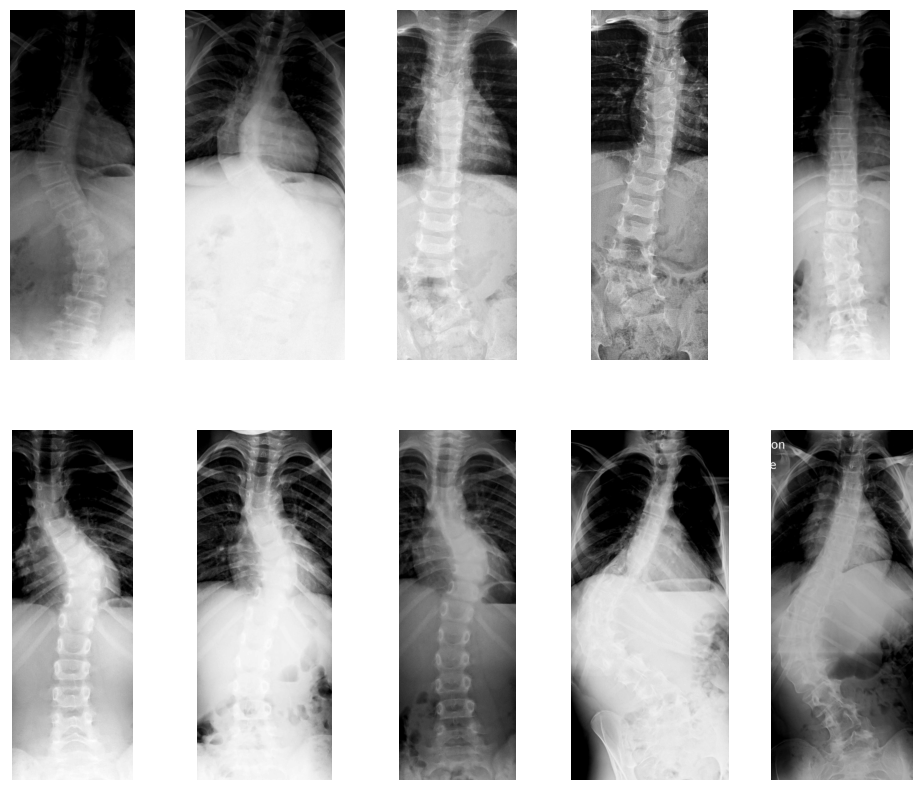

In [21]:
# visualisation
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(skio.imread(X_train[i]), cmap='gray')
    plt.axis('off')

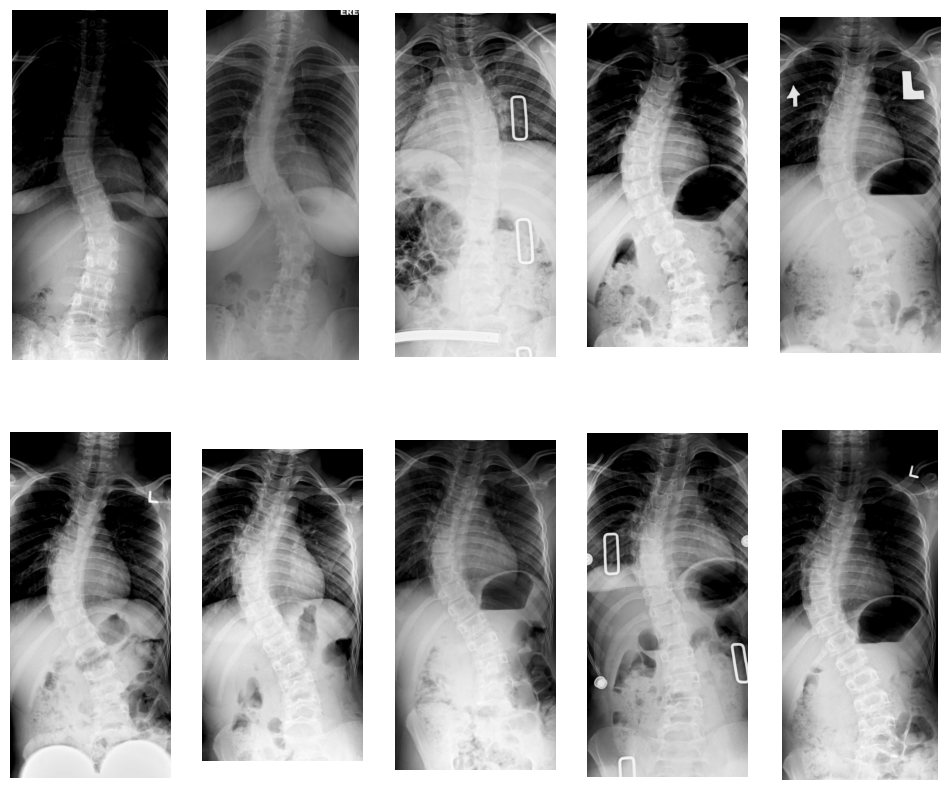

In [22]:
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(skio.imread(X_test[i]), cmap="gray")
    plt.axis("off")

### Labels

In [23]:
from scipy.io import loadmat

def load_labels_mat(dir_list):
    labels = []
    for label_dir in dir_list:
        labels.append(loadmat(label_dir)["p2"])
        # labels.append(np.load(label_dir))
    return labels   

In [24]:
labels_train = []
labels_test = []

for path in glob.glob(os.path.join(path_labels + "/training/*.mat")):
    labels_train.append(path)
for path in glob.glob(os.path.join(path_labels + "/test/*.mat")):
    labels_test.append(path)

In [25]:
print(len(labels_train), len(labels_test))

481 128


In [26]:
labels_train = load_labels_mat(labels_train)
labels_test = load_labels_mat(labels_test)

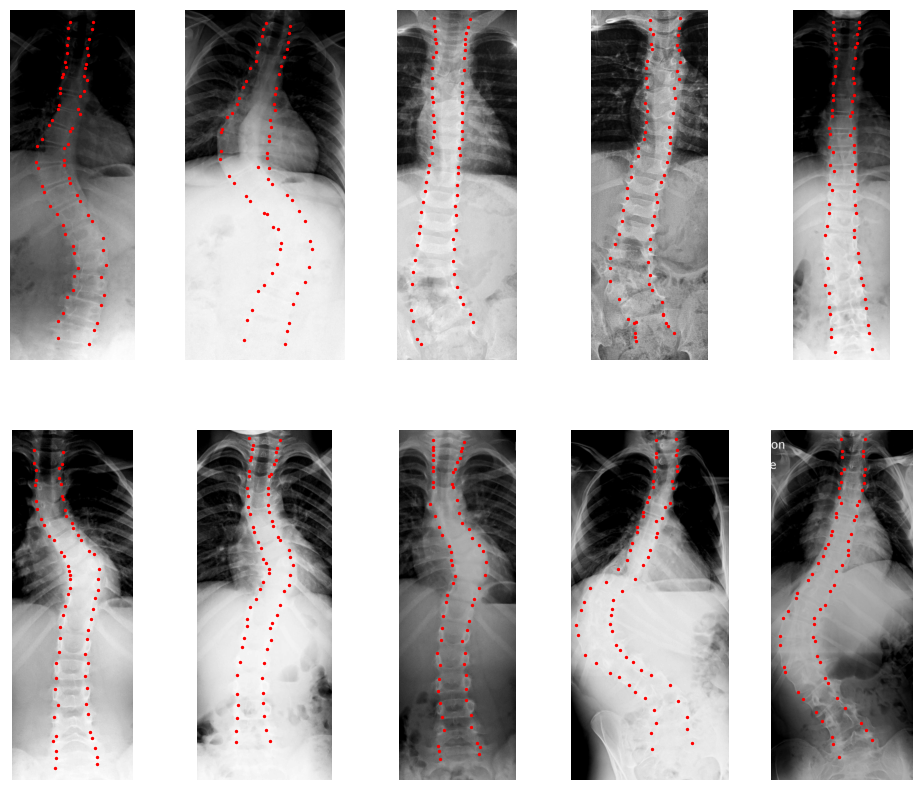

In [27]:
# visualisation
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(skio.imread(X_train[i]), cmap="gray")
    for j in range(len(labels_train[i])):
        plt.scatter(
            labels_train[i][j][0], labels_train[i][j][1], c="r", s=2
        )
    plt.axis("off")

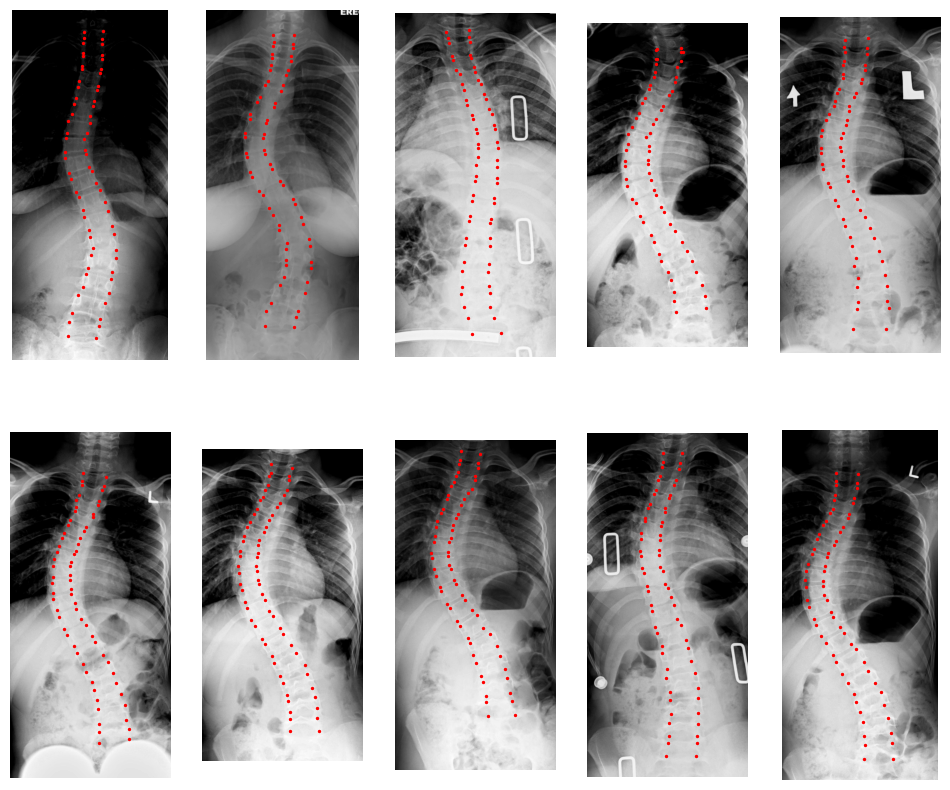

In [28]:
#visualisation
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(skio.imread(X_test[i]), cmap="gray")
    for j in range(len(labels_test[i])):
        plt.scatter(
            labels_test[i][j][0], labels_test[i][j][1], c="r", s=2
        )
    plt.axis("off")

In [29]:
from utils import get_right_landmarks, get_left_landmarks
from scipy.interpolate import CloughTocher2DInterpolator

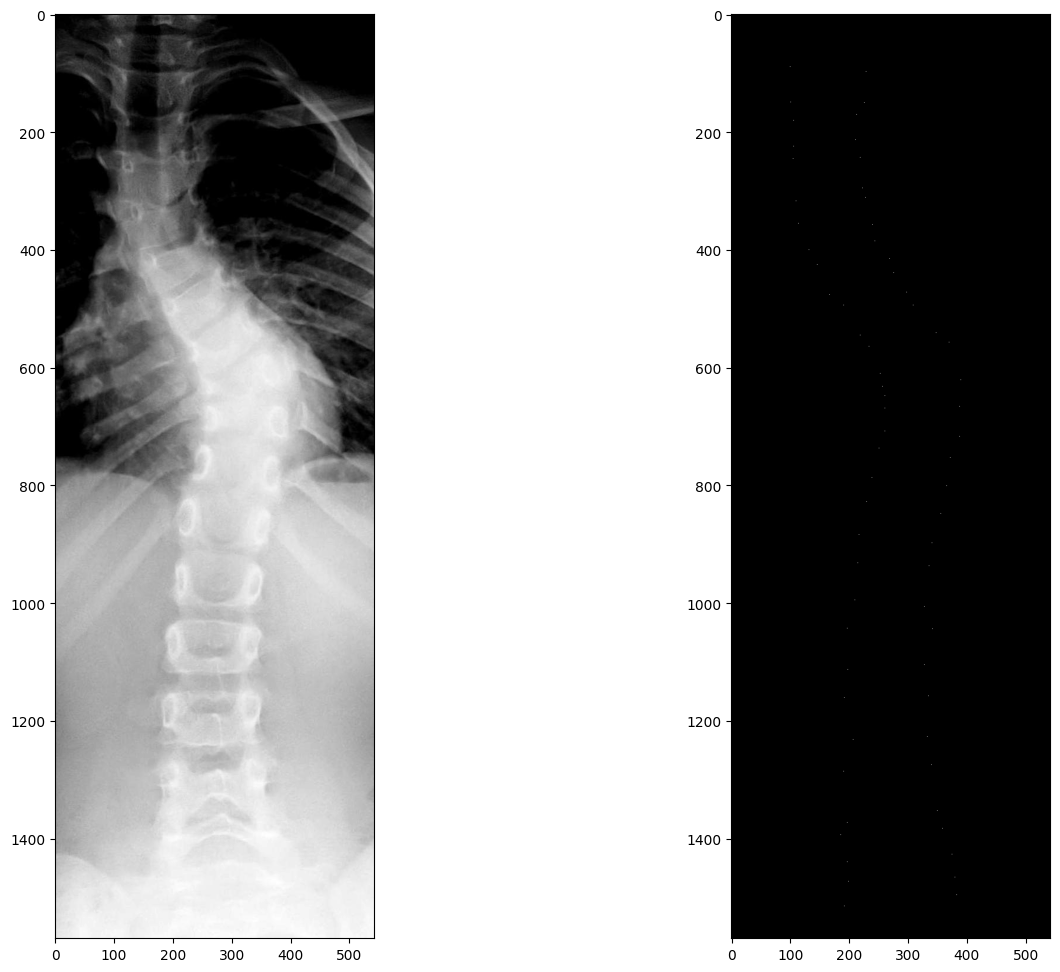

In [30]:
i = 5

labels = labels_train[i]
img = skio.imread(X_train[i])

shape = img.shape

# create a mask for the image
mask = np.zeros(shape[:2], dtype=np.uint8)

for label in labels:
    mask[int(label[1]), int(label[0])] = 1

right_ld = get_right_landmarks(labels)
left_ld = get_left_landmarks(labels)

#interpolate using scipy
interp_right = CloughTocher2DInterpolator(right_ld, np.ones(len(right_ld)))
interp_left = CloughTocher2DInterpolator(left_ld, np.ones(len(left_ld)))

print(interp_left)







plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.show()

In [31]:
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d, PchipInterpolator

In [43]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt


# Define a function to smooth and interpolate the landmarks
def smooth_landmarks(ld, shape, resolution_factor=10):
    x, y = zip(*ld)

    yrange = y[-1] - y[0]
    y_axis_high_res = np.linspace(y[0], y[-1], (yrange + 1)*resolution_factor).astype(int)

    y_begin = y[0]
    y_end = y[-1]

    interp = interp1d(y, x, kind="quadratic")

    new_x_high_res = interp(y_axis_high_res)

    y_axis = np.linspace(0, shape[0] - 1, shape[0]).astype(int)
    new_x = np.interp(y_axis, y_axis_high_res, new_x_high_res)


    # pad to shape[0]

    if y_begin > 0:
        new_x = np.pad(
            new_x, (y_begin, 0), mode="constant", constant_values=(new_x[0], new_x[0])
        )

    if y_end < shape[0]:
        new_x = np.pad(
            new_x,
            (0, shape[0] - y_end - 1),
            mode="constant",
            constant_values=(new_x[-1], new_x[-1]),
        )

    new_y = np.linspace(0, shape[0] - 1, shape[0]).astype(int)

    return np.column_stack((new_x, new_y))



right_ld = get_right_landmarks(labels)
left_ld = get_left_landmarks(labels)

shape = img.shape
# Apply smoothing to left and right landmarks
new_right_labels = smooth_landmarks(right_ld, shape)
new_left_labels = smooth_landmarks(left_ld, shape)

# Fill in between the landmarks
mask = np.zeros(shape[:2], dtype=np.uint8)

for i in range(shape[0]):
    mask[i, int(new_left_labels[i, 0]) : int(new_right_labels[i, 0])] = 1

# Plot results
plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.scatter(new_left_labels[:, 0], new_left_labels[:, 1], c="r", s=2)
plt.scatter(new_right_labels[:, 0], new_right_labels[:, 1], c="r", s=2)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1740 and the array at index 1 has size 1570

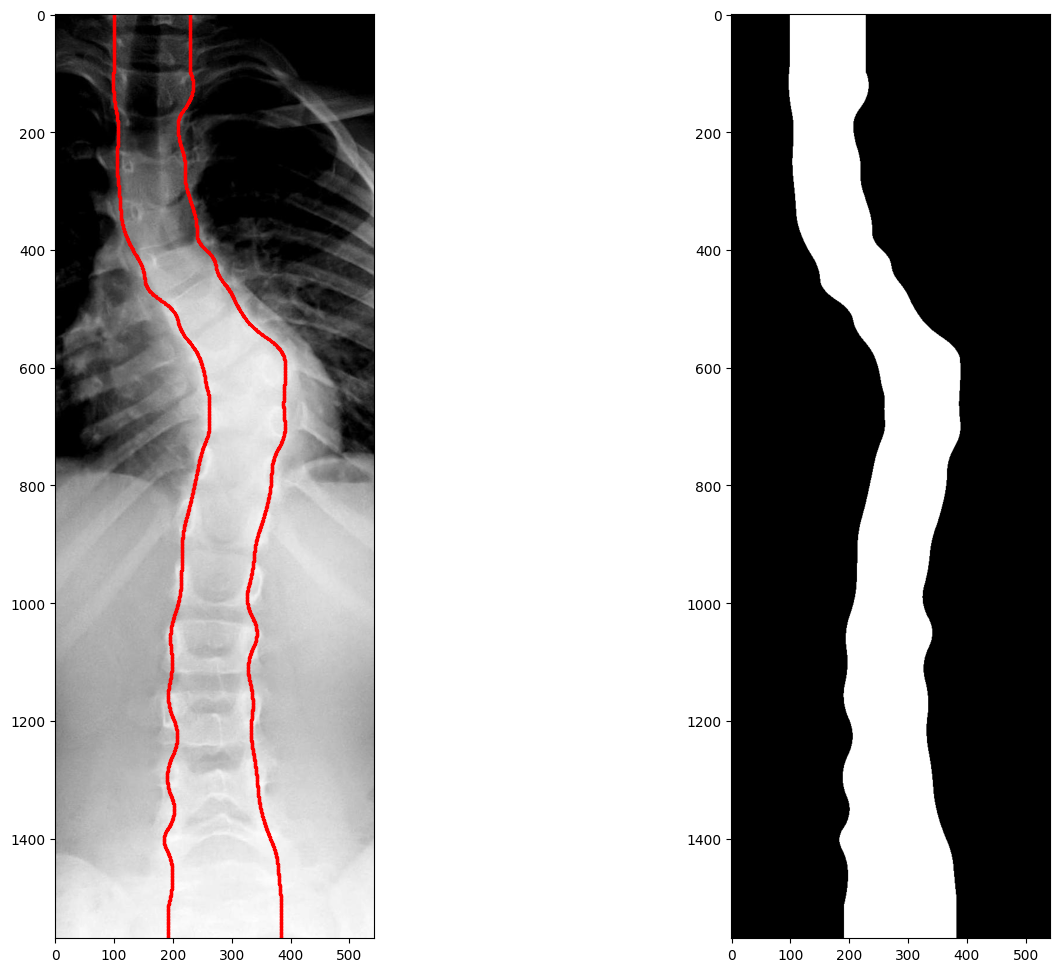

In [37]:
x,y = zip(*right_ld)

yrange = y[-1] - y[0]
y_axis = np.linspace(y[0], y[-1], yrange + 1).astype(int)

y_begin = y[0]
y_end = y[-1]

interp = interp1d(y, x, kind="quadratic")

new_x = interp(y_axis)
# pad to shape[0]

if y_begin > 0:
    new_x = np.pad(
        new_x, (y_begin, 0), mode="constant", constant_values=(new_x[0], new_x[0])
    )

if y_end < shape[0]:
    new_x = np.pad(
        new_x,
        (0, shape[0] - y_end - 1),
        mode="constant",
        constant_values=(new_x[-1], new_x[-1]),
    )

new_y = np.linspace(0, shape[0] - 1, shape[0]).astype(int)

new_right_labels = np.column_stack((new_x, new_y))

# same for left landmarks

x,y = zip(*left_ld)

yrange = y[-1] - y[0]
y_axis = np.linspace(y[0], y[-1], yrange + 1).astype(int)

y_begin = y[0]
y_end = y[-1]

interp = interp1d(y, x, kind="quadratic")

new_x = interp(y_axis)
# pad to shape[0]

if y_begin > 0:
    new_x = np.pad(new_x, (y_begin, 0), mode="constant", constant_values=(new_x[0], new_x[0]))

if y_end < shape[0]:
    new_x = np.pad(new_x, (0, shape[0] - y_end-1), mode="constant", constant_values=(new_x[-1], new_x[-1]))

new_y = np.linspace(0, shape[0] - 1, shape[0]).astype(int)

new_left_labels = np.column_stack((new_x, new_y))

# fill in between the landmarks

mask = np.zeros(shape[:2], dtype=np.uint8)


for i in range(shape[0]):
    mask[i, int(new_left_labels[i, 0]):int(new_right_labels[i, 0])] = 1

plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.scatter(new_left_labels[:, 0], new_left_labels[:, 1], c="r", s=2)
plt.scatter(new_right_labels[:, 0], new_right_labels[:, 1], c="r", s=2)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.show()